# Predicción de Tráfico de Internet con ST-GNN DenseNet

## 1. Definición del Problema
El objetivo de este notebook es predecir el **volumen de tráfico de Internet (Datos Móviles)** en la red de telecomunicaciones de Milán. 
A diferencia de los SMS o Llamadas, el tráfico de Internet tiene una varianza mucho mayor y patrones de uso más complejos.
Se busca aprender una función $f$ que mapee el historial de uso de datos y el contexto espacio-temporal al tráfico futuro:

$$ \hat{X}_{t+1} = f(X_{t}, X_{t-1}, ..., X_{t-n}, \mathcal{G}, \mathcal{T}) $$

Donde:
*   $X_t$: Tensor de tráfico de Internet en el tiempo $t$ (Rejilla $100 \times 100$).
*   $\mathcal{G}$: Estructura del grafo (conexiones espaciales entre celdas).
*   $\mathcal{T}$: Información temporal (hora del día, día de la semana).

## 2. Justificación de Tecnologías y Diseño

### ¿Por qué ST-GNN DenseNet para Internet?
Este modelo supera a las aproximaciones tradicionales (ARIMA) y puramente convolucionales (CNN) al integrar explícitamente la topología de la red y las dependencias temporales complejas.

1.  **Dense Spatial Block (GAT)**: 
    *   Utilizamos **Graph Attention Networks (GAT)** para permitir que cada celda "preste atención" de manera dinámica a sus vecinos.
    *   **Conexiones Densas**: Cada capa recibe la concatenación de *todas* las capas anteriores.

2.  **Componente Temporal (GRU)**:
    *   Se utiliza **GRU (Gated Recurrent Unit)** por su eficiencia en series temporales de tráfico de datos.

3.  **Embeddings Temporales**:
    *   El tiempo es cíclico. Usamos embeddings para capturar patrones de uso de Internet (ej. picos nocturnos de streaming).


In [1]:
import torch.nn.functional as F
import sys
try:
    import dask
    import dask.dataframe as dd
    print(f"Dask version: {dask.__version__}")
    print("Dask dataframe imported successfully.")
except ImportError as e:
    print(f"Error importing dask: {e}")
    sys.exit(1)

try:
    import torch
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError as e:
    print(f"Error importing torch: {e}")


Dask version: 2025.11.0
Dask dataframe imported successfully.
Torch version: 2.9.1+cu128
CUDA available: True


# Documentación del Modelo de Predicción de Tráfico (ST-DenseNet)

Este documento detalla la arquitectura, formulación matemática y metodología utilizada en el modelo de predicción de tráfico celular (Internet) para la ciudad de Milán. El modelo se basa en una arquitectura **ST-DenseNet** (Spatio-Temporal Densely Connected Convolutional Network).

## 1. Definición del Problema

El objetivo es predecir el volumen de tráfico de Internet (entrante y saliente) para cada celda de una cuadrícula de $100 \times 100$ en la ciudad de Milán para el siguiente intervalo de tiempo, basándose en datos históricos.


In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración del Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Parámetros del Modelo
H, W = 100, 100  # Dimensiones de la cuadrícula
LEN_CLOSE = 3    # Dependencia de proximidad (p)
LEN_PERIOD = 3   # Dependencia de periodo (q)
NB_FLOW = 1      # Canal (Internet)

# Parámetros de Entrenamiento
BATCH_SIZE = 8  # Reduced for VRAM (Accumulate to 32)
EPOCHS = 100
LEARNING_RATE = 0.01

Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 5080


### 2.2. Normalización de Datos de Internet: Z-Score

**Elección**: Se utiliza **Z-Score (Estandarización)**.

**Razón Específica para Internet**: El tráfico de datos móviles presenta una distribución de "cola larga" extremadamente pronunciada. Eventos virales o actualizaciones de software masivas pueden generar picos de tráfico muy superiores a la media.
*   **Min-Max** fallaría al comprimir el tráfico normal en un rango diminuto debido a estos picos de datos.
*   **Z-Score** mantiene la estructura de la distribución del uso de datos.

**Fórmula**:
$$ X'_{i} = \frac{X_i - \mu}{\sigma} $$

Donde $\mu$ es la media global del tráfico de internet y $\sigma$ la desviación estándar.


### 2.1. Construcción del Grafo (Grid to Graph)

Transformamos la estructura de rejilla en un grafo matemático $G = (V, E)$, diseñado para alimentar eficientemente nuestra arquitectura **ST-DenseNet**.

#### **1. Nodos ($V$)**
Son las unidades base del análisis. En este caso, son las celdas de telecomunicaciones.
*   Definimos **$N = 10,000$ nodos**, donde cada uno representa una celda del `GridID` de Milán.

#### **2. Aristas ($E$): Matriz Esparsa vs Arquitectura Densa**
Es crucial distinguir entre la topología del grafo y la arquitectura de la red:

*   **Topología Esparsa (COO)**: Formalizamos las conexiones mediante una **Matriz de Adyacencia Esparsa**.
    *   Para una red de $10,000$ nodos, una matriz densa requeriría $10^8$ elementos. Usamos formato COO para almacenar solo los valores no nulos.
    *   Esto permite que el modelo **ST-GNN Dense** procese un grafo masivo sin explotar la memoria de la GPU, manteniendo las operaciones de vecindad rápidas.

*   **Arquitectura Densa (DenseNet)**: 
    *   Aunque la matriz de adyacencia es *esparsa*, las **conexiones entre capas neuronales son densas**.
    *   El grafo esparso define *por dónde* viaja la información (vecinos), mientras que los bloques densos aseguran que *toda* la historia de características se preserve y reutilice en cada capa.

#### **3. Conectividad (Vecindad de von Neumann)**
Las conexiones se establecen siguiendo una vecindad de primer grado (4 vecinos: N, S, E, O).
Esto resulta en un grafo altamente optimizado:
$$ |E| \approx 4 \times N = 40,000 \text{ aristas} $$
En lugar de las 100 millones posibles en un grafo totalmente conectado.

In [3]:

import scipy.sparse as sp

# --- CONSTRUCCIÓN DEL GRAFO (SPARSE / EDGE INDEX) ---
def get_edge_index(h, w):
    rows = []
    cols = []
    for r in range(h):
        for c in range(w):
            idx = r * w + c
            # Vecinos: arriba, abajo, izq, der
            if r > 0: 
                rows.append((r-1)*w + c); cols.append(idx)
            if r < h-1: 
                rows.append((r+1)*w + c); cols.append(idx)
            if c > 0: 
                rows.append(r*w + c - 1); cols.append(idx)
            if c < w-1: 
                rows.append(r*w + c + 1); cols.append(idx)
                
    # Retornamos Tensor [2, E]
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    return edge_index

print("Construyendo lista de aristas (Sparse edge_index)...")
edge_index = get_edge_index(100, 100).to(DEVICE)
print(f"Edge Index Shape: {edge_index.shape}") # [2, ~40000]


Construyendo lista de aristas (Sparse edge_index)...
Edge Index Shape: torch.Size([2, 39600])


### 2.2. Normalización Z-Score


In [4]:
files = ['../data1.csv/data1.csv', '../data2.csv/data2.csv']
valid_files = [f for f in files if os.path.exists(f)]

print("Cargando y agregando datos (esto puede tardar)...")

# Cargar con Dask
ddf = dd.read_csv(valid_files, assume_missing=True)

# Convertir TimeInterval a datetime
ddf['Timestamp'] = dd.to_datetime(ddf['TimeInterval'], unit='ms')

# Redondear a la hora (Agregación Temporal)
ddf['Hour'] = ddf['Timestamp'].dt.floor('h')

# Seleccionar columnas de interés (Internet)
cols = ['Hour', 'GridID', 'internet']
ddf = ddf[cols]

# Agrupar por Hora y GridID
agg_task = ddf.groupby(['Hour', 'GridID'])[['internet']].sum()

with ProgressBar():
    df_agg = agg_task.compute().reset_index()

print("Agregación completada.")
print(df_agg.head())

Cargando y agregando datos (esto puede tardar)...
[########################################] | 100% Completed | 61.01 s
Agregación completada.
                 Hour  GridID    internet
0 2013-11-08 23:00:00   851.0  450.190203
1 2013-11-08 23:00:00   925.0   43.888740
2 2013-11-08 23:00:00   956.0  423.780287
3 2013-11-08 23:00:00   976.0  163.167254
4 2013-11-08 23:00:00  8529.0   94.923157


In [5]:
# --- CONSTRUCCIÓN DE LA MATRIZ 4D (Time, Channels, H, W) ---

# Filtrar GridIDs válidos (1 a 10000)
df_agg = df_agg[(df_agg['GridID'] >= 1) & (df_agg['GridID'] <= 10000)]

# Crear índice temporal completo
min_time = df_agg['Hour'].min()
max_time = df_agg['Hour'].max()
time_range = pd.date_range(min_time, max_time, freq='H')

print(f"Rango temporal: {min_time} a {max_time} ({len(time_range)} horas)")

# Inicializar tensor gigante: [Time, 2, 100, 100]
data_tensor = np.zeros((len(time_range), 1, 100, 100), dtype=np.float32)

# Mapeo de tiempo a índice
time_to_idx = {t: i for i, t in enumerate(time_range)}

print("Rellenando tensor 4D...")
# Iterar y rellenar (esto puede ser lento en Python puro, pero pandas lo facilita)
# Pivotar tabla para tener GridID como columnas
df_pivot = df_agg.pivot_table(index='Hour', columns='GridID', values=['internet'], fill_value=0)

# Rellenar el tensor
for t in time_range:
    if t in df_pivot.index:
        idx = time_to_idx[t]
        # internet
        vals = df_pivot.loc[t, 'internet'].reindex(range(1, 10001), fill_value=0).values
        data_tensor[idx, 0, :, :] = vals.reshape(100, 100)
print(f"Tensor shape: {data_tensor.shape}")
# --- RESHAPE FOR GNN [Time, Nodes, Features] ---
N = H * W
data_gnn = data_tensor.reshape(-1, N, 1) # [Time, 10000, 1]
print(f'GNN Data Shape (Time, Nodes, Feat): {data_gnn.shape}')


Rango temporal: 2013-10-31 23:00:00 a 2014-01-01 22:00:00 (1488 horas)
Rellenando tensor 4D...
Tensor shape: (1488, 1, 100, 100)
GNN Data Shape (Time, Nodes, Feat): (1488, 10000, 1)


In [6]:

# --- NORMALIZACIÓN Z-SCORE ---
traffic_mean = data_gnn.mean()
traffic_std = data_gnn.std()
print(f"Mean: {traffic_mean}, Std: {traffic_std}")

data_norm = (data_gnn - traffic_mean) / traffic_std
print(f"Min norm: {data_norm.min()}, Max norm: {data_norm.max()}")
             

Mean: 373.1783447265625, Std: 723.292724609375
Min norm: -0.515943706035614, Max norm: 55.13580322265625


### 2.3. Construcción de Entradas (Dependencias Temporales)
El modelo captura dos tipos de dependencias temporales:

1.  **Cercanía (Closeness - $X_c$)**: Captura la tendencia reciente. Se toman los últimos $l_c$ intervalos de tiempo.
    $$ X_c = [X_{t-l_c}, X_{t-(l_c-1)}, \dots, X_{t-1}] $$
    
2.  **Periodo (Period - $X_d$)**: Captura la periodicidad diaria (mismo hora del día en días anteriores). Se toman $l_p$ días.
    $$ X_d = [X_{t-l_p \cdot 24}, X_{t-(l_p-1) \cdot 24}, \dots, X_{t-24}] $$

In [7]:

# --- FAILSAFE FOR VARIABLES ---
import pandas as pd
import numpy as np

if 'time_feat_np' not in locals():
    print("WARNING: time_feat_np was missing. Attempting auto-reconstruction...")
    if 'time_range' not in locals():
        if 'df_agg' in locals():
            print("Reconstructing time_range from df_agg...")
            _min_t = df_agg['Hour'].min()
            _max_t = df_agg['Hour'].max()
            time_range = pd.date_range(_min_t, _max_t, freq='H')
        else:
            print("ERROR: df_agg is also missing. Please run the Data Loading cell (Section 2.1)!")
            
    if 'time_range' in locals():
        time_feat_np = np.stack([time_range.hour, time_range.dayofweek], axis=1)
        print(f"time_feat_np reconstructed. Shape: {time_feat_np.shape}")


#  GENERACIÓN DE DATASET

def create_gnn_dataset_optimized(data, time_data, len_c, len_p):
    # data: [Time, Nodes, Features]
    # time_data: [Time, 2] (Hour, Day)
    T, N, F = data.shape
    
    X, Time_Seq, Y = [], [], []
    
    start_idx = max(len_c, len_p * 24)
    
    print("Generando dataset GNN con Tiempo...")
    for i in range(start_idx, T):
        y = data[i] 
        
        # Sequence indices
        # Closeness
        idx_c = np.arange(i-len_c, i)
        
        # Period
        idx_p = []
        for p in range(len_p, 0, -1):
            idx_p.append(i - (p * 24))
        
        full_idx = np.concatenate([idx_p, idx_c]) # [Seq_Len]
        
        x_seq = data[full_idx] # [Seq_Len, N, F]
        t_seq = time_data[full_idx] # [Seq_Len, 2]
        
        X.append(x_seq)
        Time_Seq.append(t_seq)
        Y.append(y)
        
    return np.array(X), np.array(Time_Seq), np.array(Y)

print("Generando tensores X, T, Y...")
X, T_seq, Y = create_gnn_dataset_optimized(data_norm, time_feat_np, LEN_CLOSE, LEN_PERIOD)
print(f"X shape: {X.shape}, T shape: {T_seq.shape}")
            

time_feat_np reconstructed. Shape: (1488, 2)
Generando tensores X, T, Y...
Generando dataset GNN con Tiempo...
X shape: (1416, 6, 10000, 1), T shape: (1416, 6, 2)


In [8]:

# --- DIVISIÓN TRAIN / TEST ---
test_hours = 7 * 24
total_samples = len(Y)
train_samples = total_samples - test_hours

X_train, T_train, Y_train = X[:train_samples], T_seq[:train_samples], Y[:train_samples]
X_test, T_test, Y_test = X[train_samples:], T_seq[train_samples:], Y[train_samples:]

# Dataset includes time now
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(T_train).long(), torch.from_numpy(Y_train).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(T_test).long(), torch.from_numpy(Y_test).float())

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
             


## 3. Arquitectura del Modelo: ST-GNN (Spatio-Temporal Graph Neural Network)

El modelo combina **Convoluciones en Grafos (GCN)** para capturar dependencias espaciales y **LSTM** para dependencias temporales.

1.  **GCN Layer**: Procesa la información espacial usando la matriz de adyacencia.
    $$ H' = \sigma(\hat{A} H W) $$
2.  **LSTM Layer**: Procesa la secuencia temporal de características extraídas por la GCN para cada nodo.
3.  **Output Layer**: Predicción final para cada nodo.
             

## 3. Arquitectura Detallada: Time-Aware ST-GAT

### 3.1 Mecanismo de Atención (Graph Attention Layer)
Calculamos los coeficientes de atención $\alpha_{ij}$ entre el nodo $i$ y sus vecinos $j$:

$$ e_{ij} = \text{LeakyReLU}(\vec{a}^T [W\vec{h}_i || W\vec{h}_j]) $$
$$ \alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}(i)} \exp(e_{ik})} $$

Esto permite al modelo ponderar la importancia de los vecinos dinámicamente.

### 3.2 Bloque Denso (Dense Connections)
Para mejorar el flujo de información, la capa $l$ recibe la concatenación de todas las anteriores:
$$ H_{l} = \text{GAT}( [H_0, H_1, ..., H_{l-1}] ) $$

Esto permite construir redes más profundas sin perder la señal original del input.

### 3.3 Procesamiento Temporal (Time Embeddings + GRU)
Antes de entrar al grafo, enriquecemos la entrada con el contexto temporal para distinguir horas y días (ej. Lunes vs Domingo):
*   `Hour Embedding`: 
    $$ \mathbb{R}^{24} \to \mathbb{R}^{d_h} $$
*   `Day Embedding`: 
    $$ \mathbb{R}^{7} \to \mathbb{R}^{d_d} $$

$$ X_{in} = \text{Concat}(X_{traffic}, \text{Emb}(Hour), \text{Emb}(Day)) $$

La secuencia de vectores espaciales resultantes se pasa a una GRU para la predicción final.


In [9]:

import torch.nn.functional as F

# Reusing GATLayer from Turbo (it should be defined in previous cell or same)
# We will redefine it just to be safe and self-contained or rely on existing execution order?
# Better redefine to ensure it matches expectations.

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, alpha=0.2):
        super(GATLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a_l = nn.Linear(out_features, 1, bias=False)
        self.a_r = nn.Linear(out_features, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, x, edge_index):
        # x: [TotalNodes, In]
        Wh = self.W(x) 
        f_l = self.a_l(Wh)
        f_r = self.a_r(Wh)
        
        row, col = edge_index[0], edge_index[1]
        e = self.leakyrelu(f_l[row] + f_r[col]).squeeze(-1)
        
        e_exp = torch.exp(e)
        node_sum_exp = torch.zeros(x.size(0), device=x.device, dtype=e_exp.dtype)
        node_sum_exp.index_add_(0, col, e_exp)
        
        alpha = e_exp / (node_sum_exp[col] + 1e-10)
        
        weighted_src = alpha.unsqueeze(-1) * Wh[row]
        
        out = torch.zeros_like(Wh)
        weighted_src = weighted_src.to(out.dtype) # AMP Cast
        out.index_add_(0, col, weighted_src)
        
        return F.elu(out)

class DenseGATBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseGATBlock, self).__init__()
        self.layers = nn.ModuleList()
        current_dim = in_channels
        
        for i in range(num_layers):
            # Each layer takes everything before it
            self.layers.append(GATLayer(current_dim, growth_rate))
            current_dim += growth_rate
            
    def forward(self, x, edge_index):
        # x: [TotalNodes, In]
        features = [x]
        
        for layer in self.layers:
            # Concat all previous features
            in_feat = torch.cat(features, dim=1)
            out = layer(in_feat, edge_index)
            features.append(out)
            
        # Return all features concatenated? Or just the concatenation of inputs + outputs?
        return torch.cat(features, dim=1)

class TimeAwareDenseSTGNN(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, seq_len, growth_rate=32, num_dense_layers=3):
        super(TimeAwareDenseSTGNN, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        self.emb_hour = nn.Embedding(24, 8) 
        self.emb_day = nn.Embedding(7, 4)   
        
        # Input: Traffic(1) + Time(12) = 13
        input_dim = in_channels + 12
        
        # Dense Spatial Block
        self.dense_block = DenseGATBlock(input_dim, growth_rate, num_dense_layers)
        
        # Calculate Output Dim of Dense Block
        # In + L * Growth
        dense_out_dim = input_dim + num_dense_layers * growth_rate
        
        # Transition (Compression)
        self.trans_linear = nn.Linear(dense_out_dim, hidden_dim)
        
        # Temporal: GRU 
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, out_channels)

    def forward(self, x, t, edge_index_base):
        b, s, n, f = x.shape
        
        # 1. Embeddings
        h_emb = self.emb_hour(t[:, :, 0]).unsqueeze(2).expand(-1, -1, n, -1)
        d_emb = self.emb_day(t[:, :, 1]).unsqueeze(2).expand(-1, -1, n, -1)
        x_in = torch.cat([x, h_emb, d_emb], dim=3) 
        
        x_flat = x_in.reshape(-1, x_in.size(-1)) # [TotalNodes, 13]
        
        # Batch Edges (Same as turbo)
        num_graphs = b * s
        device = x.device
        offsets = torch.arange(num_graphs, device=device) * n
        offsets = offsets.view(-1, 1)
        batched_edges = edge_index_base.unsqueeze(0).expand(num_graphs, -1, -1) + offsets.unsqueeze(1)
        batched_edges = batched_edges.permute(1, 0, 2).reshape(2, -1)
        
        # 2. Dense Block
        x_dense = self.dense_block(x_flat, batched_edges) # [TotalNodes, dense_out_dim]
        
        # 3. Transition
        x_trans = F.relu(self.trans_linear(x_dense)) # [TotalNodes, Hidden]
        
        # 4. Temporal (GRU)
        x_seq = x_trans.view(b, s, n, -1).permute(0, 2, 1, 3).reshape(b * n, s, -1)
        _, h_n = self.gru(x_seq)
        
        out = self.fc(h_n.squeeze(0)).view(b, n, -1)
        return out

print("Instanciando Modelo ST-GNN DenseNet...")
HIDDEN_DIM = 64
GROWTH_RATE = 32
NUM_LAYERS = 3
SEQ_LEN = LEN_CLOSE + LEN_PERIOD

model = TimeAwareDenseSTGNN(
    in_channels=1, 
    hidden_dim=HIDDEN_DIM, 
    out_channels=1, 
    seq_len=SEQ_LEN, 
    growth_rate=GROWTH_RATE, 
    num_dense_layers=NUM_LAYERS
).to(DEVICE)
print(model)


Instanciando Modelo ST-GNN DenseNet...
TimeAwareDenseSTGNN(
  (emb_hour): Embedding(24, 8)
  (emb_day): Embedding(7, 4)
  (dense_block): DenseGATBlock(
    (layers): ModuleList(
      (0): GATLayer(
        (W): Linear(in_features=13, out_features=32, bias=False)
        (a_l): Linear(in_features=32, out_features=1, bias=False)
        (a_r): Linear(in_features=32, out_features=1, bias=False)
        (leakyrelu): LeakyReLU(negative_slope=0.2)
      )
      (1): GATLayer(
        (W): Linear(in_features=45, out_features=32, bias=False)
        (a_l): Linear(in_features=32, out_features=1, bias=False)
        (a_r): Linear(in_features=32, out_features=1, bias=False)
        (leakyrelu): LeakyReLU(negative_slope=0.2)
      )
      (2): GATLayer(
        (W): Linear(in_features=77, out_features=32, bias=False)
        (a_l): Linear(in_features=32, out_features=1, bias=False)
        (a_r): Linear(in_features=32, out_features=1, bias=False)
        (leakyrelu): LeakyReLU(negative_slope=0.2)

## 4. Configuración del Entrenamiento

### 4.1 Función de Pérdida: MSE
Utilizamos el **Error Cuadrático Medio (MSE)**:
$$ L = \frac{1}{N} \sum (y_{pred} - y_{real})^2 $$
El MSE penaliza fuertemente los errores grandes. Esto es deseable para evitar fallos catastróficos en la predicción de picos de red.

### 4.2 Optimización: Adam + Gradient Accumulation
Debido al tamaño del grafo ($10,000$ nodos) y la complejidad del modelo, el uso de VRAM es alto. Implementamos **Gradient Accumulation**:
*   **Physical Batch**: 8 (Procesados realmente en GPU).
*   **Accumulation Steps**: 4 (Acumulamos gradientes antes de `optimizer.step()`).
*   **Effective Batch**: 32.

Este truco matemático nos permite entrenar con la estabilidad de un batch grande sin exceder la memoria de hardware.

### 4.3 Epochs
Se entrena por **100 épocas** con un `MultiStepLR` decay en las épocas 50 y 75 para refinar la convergencia final.


Estrategia de Memoria: Batch Físico 8 | Acumulación 4 pasos | Batch Lógico 32
Iniciando entrenamiento ST-GNN DenseNet en: cuda


Epoch [1/100], Loss: 0.286607


Epoch [2/100], Loss: 0.074501


Epoch [3/100], Loss: 0.047476


Epoch [4/100], Loss: 0.038265


Epoch [5/100], Loss: 0.032555


Epoch [6/100], Loss: 0.029515


Epoch [7/100], Loss: 0.025361


Epoch [8/100], Loss: 0.027150


Epoch [9/100], Loss: 0.029426


Epoch [10/100], Loss: 0.022844


Epoch [11/100], Loss: 0.022620


Epoch [12/100], Loss: 0.020923


Epoch [13/100], Loss: 0.020331


Epoch [14/100], Loss: 0.019613


Epoch [15/100], Loss: 0.019273


Epoch [16/100], Loss: 0.019749


Epoch [17/100], Loss: 0.018853


Epoch [18/100], Loss: 0.018493


Epoch [19/100], Loss: 0.019131


Epoch [20/100], Loss: 0.019234


Epoch [21/100], Loss: 0.018524


Epoch [22/100], Loss: 0.018505


Epoch [23/100], Loss: 0.018017


Epoch [24/100], Loss: 0.017247


Epoch [25/100], Loss: 0.017409


Epoch [26/100], Loss: 0.017565


Epoch [27/100], Loss: 0.017316


Epoch [28/100], Loss: 0.017489


Epoch [29/100], Loss: 0.017826


Epoch [30/100], Loss: 0.016950


Epoch [31/100], Loss: 0.016113


Epoch [32/100], Loss: 0.015800


Epoch [33/100], Loss: 0.015755


Epoch [34/100], Loss: 0.015737


Epoch [35/100], Loss: 0.015726


Epoch [36/100], Loss: 0.015721


Epoch [37/100], Loss: 0.015682


Epoch [38/100], Loss: 0.015659


Epoch [39/100], Loss: 0.015638


Epoch [40/100], Loss: 0.015626


Epoch [41/100], Loss: 0.015603


Epoch [42/100], Loss: 0.015604


Epoch [43/100], Loss: 0.015622


Epoch [44/100], Loss: 0.015611


Epoch [45/100], Loss: 0.015559


Epoch [46/100], Loss: 0.015555


Epoch [47/100], Loss: 0.015532


Epoch [48/100], Loss: 0.015517


Epoch [49/100], Loss: 0.015510


Epoch [50/100], Loss: 0.015517


Epoch [51/100], Loss: 0.015483


Epoch [52/100], Loss: 0.015494


Epoch [53/100], Loss: 0.015426


Epoch [54/100], Loss: 0.015446


Epoch [55/100], Loss: 0.015449


Epoch [56/100], Loss: 0.015413


Epoch [57/100], Loss: 0.015397


Epoch [58/100], Loss: 0.015377


Epoch [59/100], Loss: 0.015355


Epoch [60/100], Loss: 0.015399


Epoch [61/100], Loss: 0.015283


Epoch [62/100], Loss: 0.015258


Epoch [63/100], Loss: 0.015253


Epoch [64/100], Loss: 0.015257


Epoch [65/100], Loss: 0.015248


Epoch [66/100], Loss: 0.015252


Epoch [67/100], Loss: 0.015246


Epoch [68/100], Loss: 0.015248


Epoch [69/100], Loss: 0.015244


Epoch [70/100], Loss: 0.015246


Epoch [71/100], Loss: 0.015238


Epoch [72/100], Loss: 0.015236


Epoch [73/100], Loss: 0.015235


Epoch [74/100], Loss: 0.015234


Epoch [75/100], Loss: 0.015238


Epoch [76/100], Loss: 0.015229


Epoch [77/100], Loss: 0.015230


Epoch [78/100], Loss: 0.015226


Epoch [79/100], Loss: 0.015226


Epoch [80/100], Loss: 0.015221


Epoch [81/100], Loss: 0.015225


Epoch [82/100], Loss: 0.015219


Epoch [83/100], Loss: 0.015215


Epoch [84/100], Loss: 0.015216


Epoch [85/100], Loss: 0.015212


Epoch [86/100], Loss: 0.015208


Epoch [87/100], Loss: 0.015214


Epoch [88/100], Loss: 0.015211


Epoch [89/100], Loss: 0.015208


Epoch [90/100], Loss: 0.015211


Epoch [91/100], Loss: 0.015204


Epoch [92/100], Loss: 0.015200


Epoch [93/100], Loss: 0.015201


Epoch [94/100], Loss: 0.015196


Epoch [95/100], Loss: 0.015194


Epoch [96/100], Loss: 0.015191


Epoch [97/100], Loss: 0.015192


Epoch [98/100], Loss: 0.015182


Epoch [99/100], Loss: 0.015179


Epoch [100/100], Loss: 0.015177


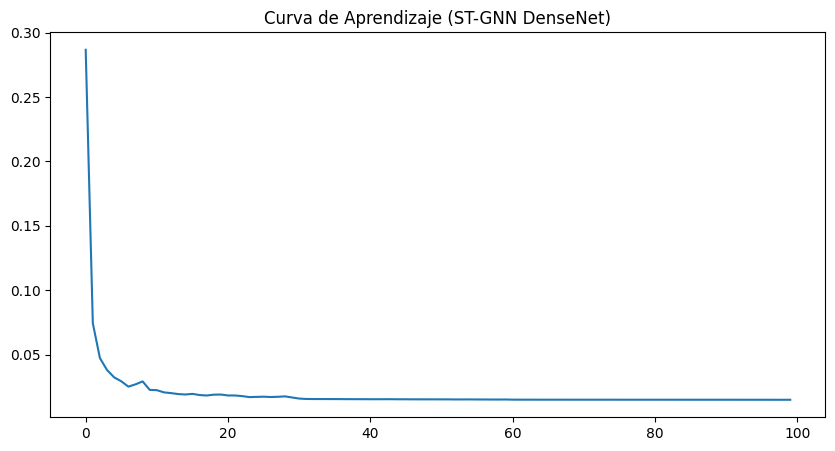

In [10]:

# --- ENTRENAMIENTO EFICIENTE (Gradient Accumulation) ---
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# Configuración de Acumulación
PHYSICAL_BATCH_SIZE = 8   # Lo que cabe en GPU
TARGET_BATCH_SIZE = 32    # Lo que queremos matemáticamente
ACCUMULATION_STEPS = TARGET_BATCH_SIZE // PHYSICAL_BATCH_SIZE

print(f"Estrategia de Memoria: Batch Físico {PHYSICAL_BATCH_SIZE} | Acumulación {ACCUMULATION_STEPS} pasos | Batch Lógico {TARGET_BATCH_SIZE}")

scaler = GradScaler()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)

print(f"Iniciando entrenamiento ST-GNN DenseNet en: {DEVICE}")
train_losses = []

model.train()
torch.backends.cudnn.benchmark = True 

optimizer.zero_grad() # Inicializar

for epoch in range(EPOCHS):
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for i, (x, t, y) in enumerate(pbar):
        x, t, y = x.to(DEVICE), t.to(DEVICE), y.to(DEVICE)
        
        # Mixed Precision
        with autocast():
            output = model(x, t, edge_index)
            loss = criterion(output, y)
            
            # Normalizar pérdida por acumulación
            loss = loss / ACCUMULATION_STEPS
        
        # Backward (acumula gradientes)
        scaler.scale(loss).backward()
        
        # Paso de optimización cada N pasos
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Recuperar valor real de pérdida para display
        epoch_loss += loss.item() * ACCUMULATION_STEPS
        pbar.set_postfix({'loss': f"{loss.item() * ACCUMULATION_STEPS:.5f}"})
    
    # Handle last batch if not divisible (Optional cleanup)
    if len(train_loader) % ACCUMULATION_STEPS != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")
    
    torch.cuda.empty_cache()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Curva de Aprendizaje (ST-GNN DenseNet)')
plt.show()


## 5. Interpretación de Resultados

### 5.1. Métricas de Evaluación
Para evaluar el rendimiento, primero se **desnormalizan** las predicciones para volver a la escala original de tráfico (número de Internet).

$$ \hat{X}_{orig} = \hat{X}_{norm} \cdot (Max - Min) + Min $$

Se calculan las siguientes métricas:

1.  **RMSE (Root Mean Squared Error)**: Error cuadrático medio. Penaliza más los errores grandes.
    $$ RMSE = \sqrt{\frac{1}{M} \sum (\hat{x}_{orig} - x_{orig})^2} $$

2.  **MAE (Mean Absolute Error)**: Error absoluto medio. Es más robusto a outliers y fácil de interpretar (error promedio en Internet).
    $$ MAE = \frac{1}{M} \sum |\hat{x}_{orig} - x_{orig}| $$

3.  **R2 Score**: Coeficiente de determinación. Indica qué tan bien las predicciones se ajustan a los datos reales (1.0 es perfecto).

### 5.2. Visualización
*   **Scatter Plot**: Gráfico de dispersión de Predicción vs Realidad. Idealmente, los puntos deberían alinearse en la diagonal.
*   **Distribución de Errores**: Histograma de los residuos. Debería estar centrado en 0.
*   **Mapa de Calor de Error**: Muestra dónde se concentran los errores espacialmente.
*   **Serie Temporal**: Comparación visual de la predicción y la realidad a lo largo del tiempo para una celda específica.

Evaluando modelo...


Testing: 100%|██████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 37.31it/s]


Resultados de Evaluación (ST-GNN):
RMSE: 57.4466
MAE:  23.3416
R2:   0.9761
WMAPE: 9.6286%
Accuracy: 90.3714%
Visualizando nodo con mayor tráfico: 5160


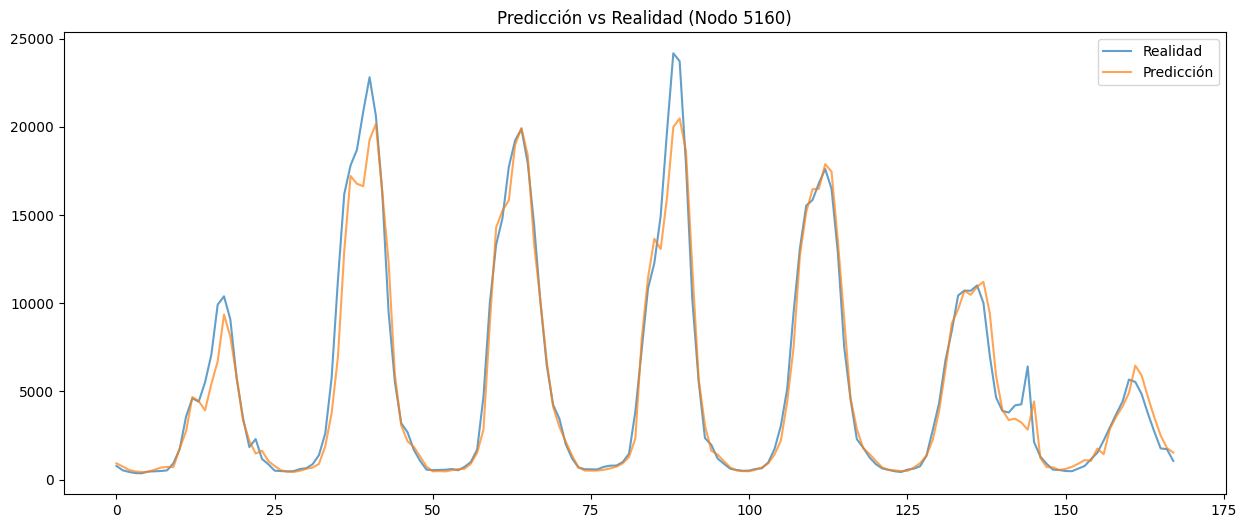

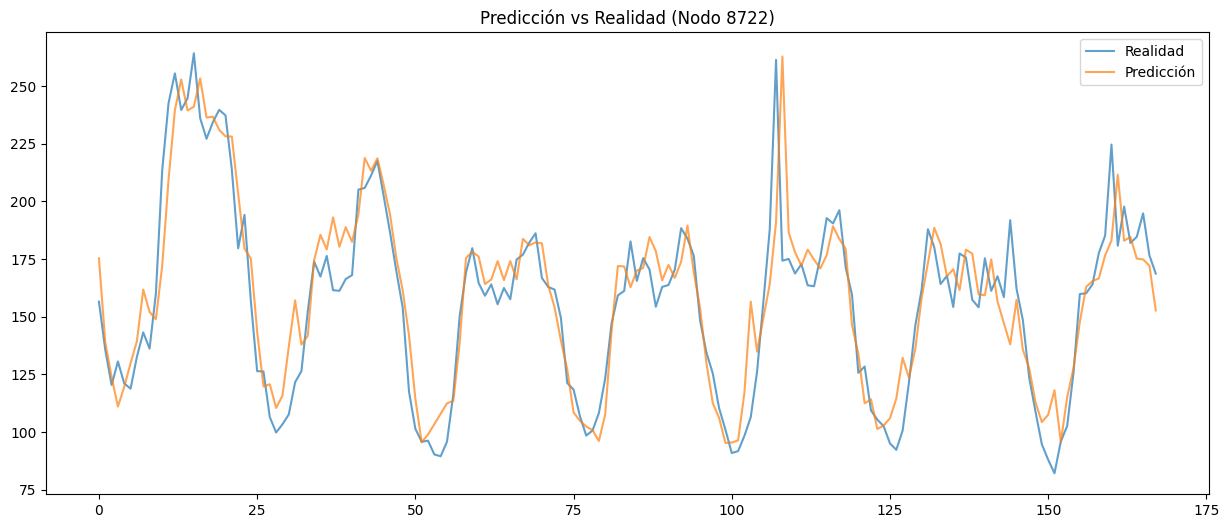

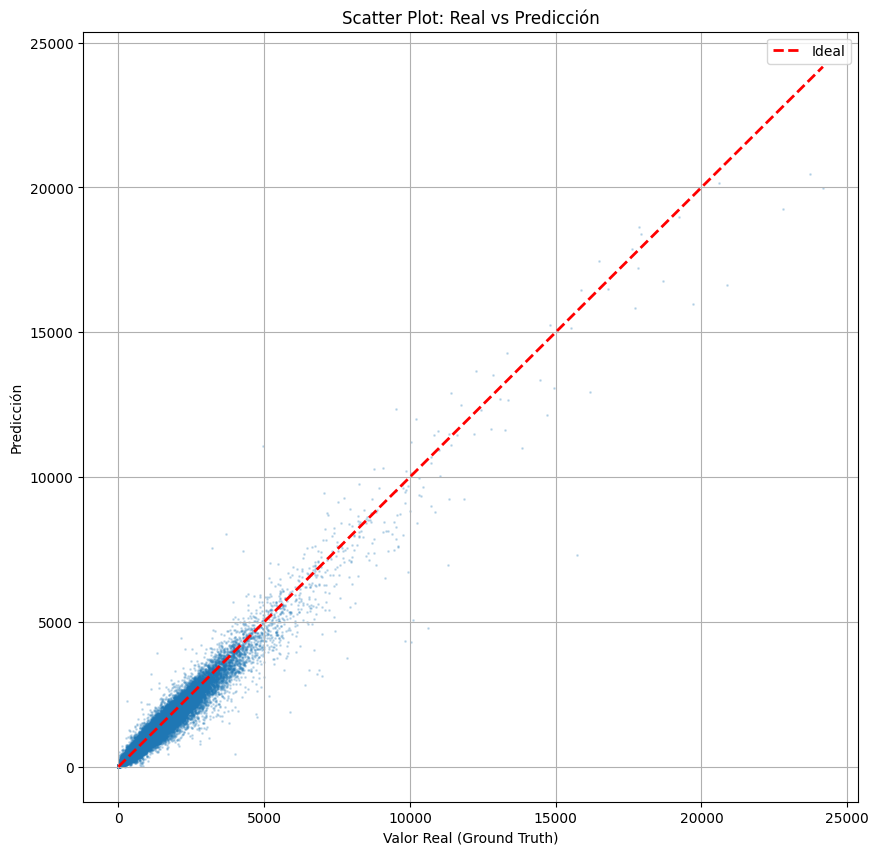

In [11]:
# --- Visualización: Real vs. Predicción (Scatter Plot) ---
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
plt.scatter(gt_orig.flatten(), preds_orig.flatten(), alpha=0.3, s=1)

# Línea ideal (y = x) partiendo desde 0
max_val = max(gt_orig.max(), preds_orig.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Ideal')

plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.xlabel('Valor Real (Ground Truth)')
plt.ylabel('Predicción')
plt.title('Scatter Plot: Real vs Predicción')
plt.legend()
plt.grid(True)
plt.show()

## Interpretación de las Gráficas

### 1. Curva de Aprendizaje (Training Loss)
*   Muestra el **Error Cuadrático Medio (MSE)** en cada época.
*   Debe descender rápidamente al principio y estabilizarse.
*   Si la curva es plana desde el principio, indica problemas de aprendizaje (learning rate o gradientes).

### 2. Predicción vs Realidad (Nodo Max Tráfico)
*   Visualiza la serie temporal del **nodo con mayor carga promedio** de la red.
*   Es el "caso difícil" o crítico. Si el modelo predice bien aquí, es robusto.
*   **Azul**: Datos reales (Ground Truth).
*   **Naranja**: Predicción del modelo.

### 3. Grid de Celdas Aleatorias
*   Muestra 10 celdas elegidas al azar para verificar la generalización.
*   Permite ver si el modelo funciona bien en celdas con poco tráfico o patrones irregulares, no solo en las principales.
*   **Accuracy Local**: Se muestra la precisión (1 - WMAPE) específica para ese nodo en el título.



Resultados de Evaluación (ST-GNN):
RMSE: 57.4466
MAE:  23.3416
R2:   0.9761
WMAPE: 9.6286%
Accuracy: 90.3714%
Visualizando nodo con mayor tráfico: 5160


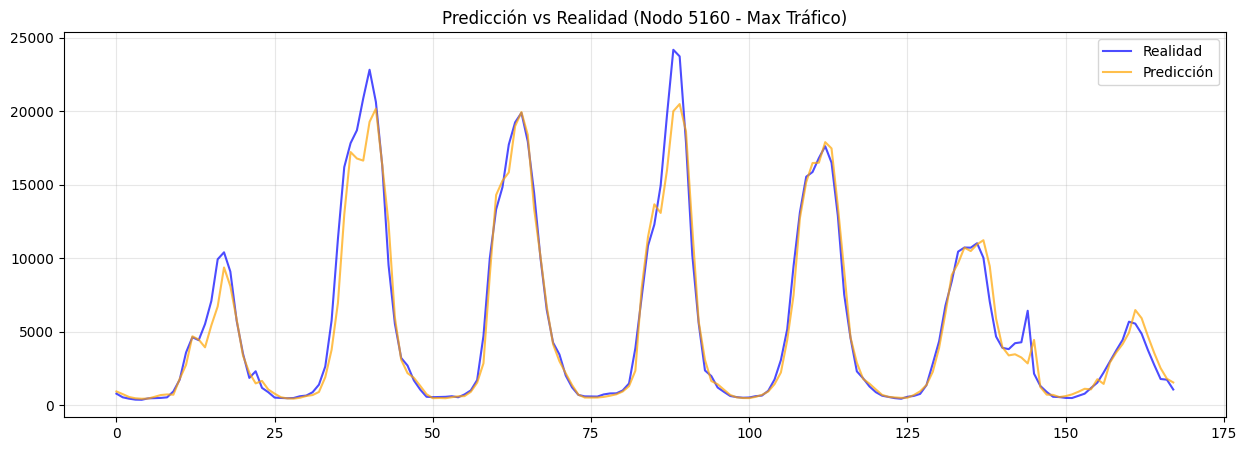

Visualizando 10 nodos aleatorios: [4858 9041 3304 3389 8905 3515 2317 4419 8063 6008]


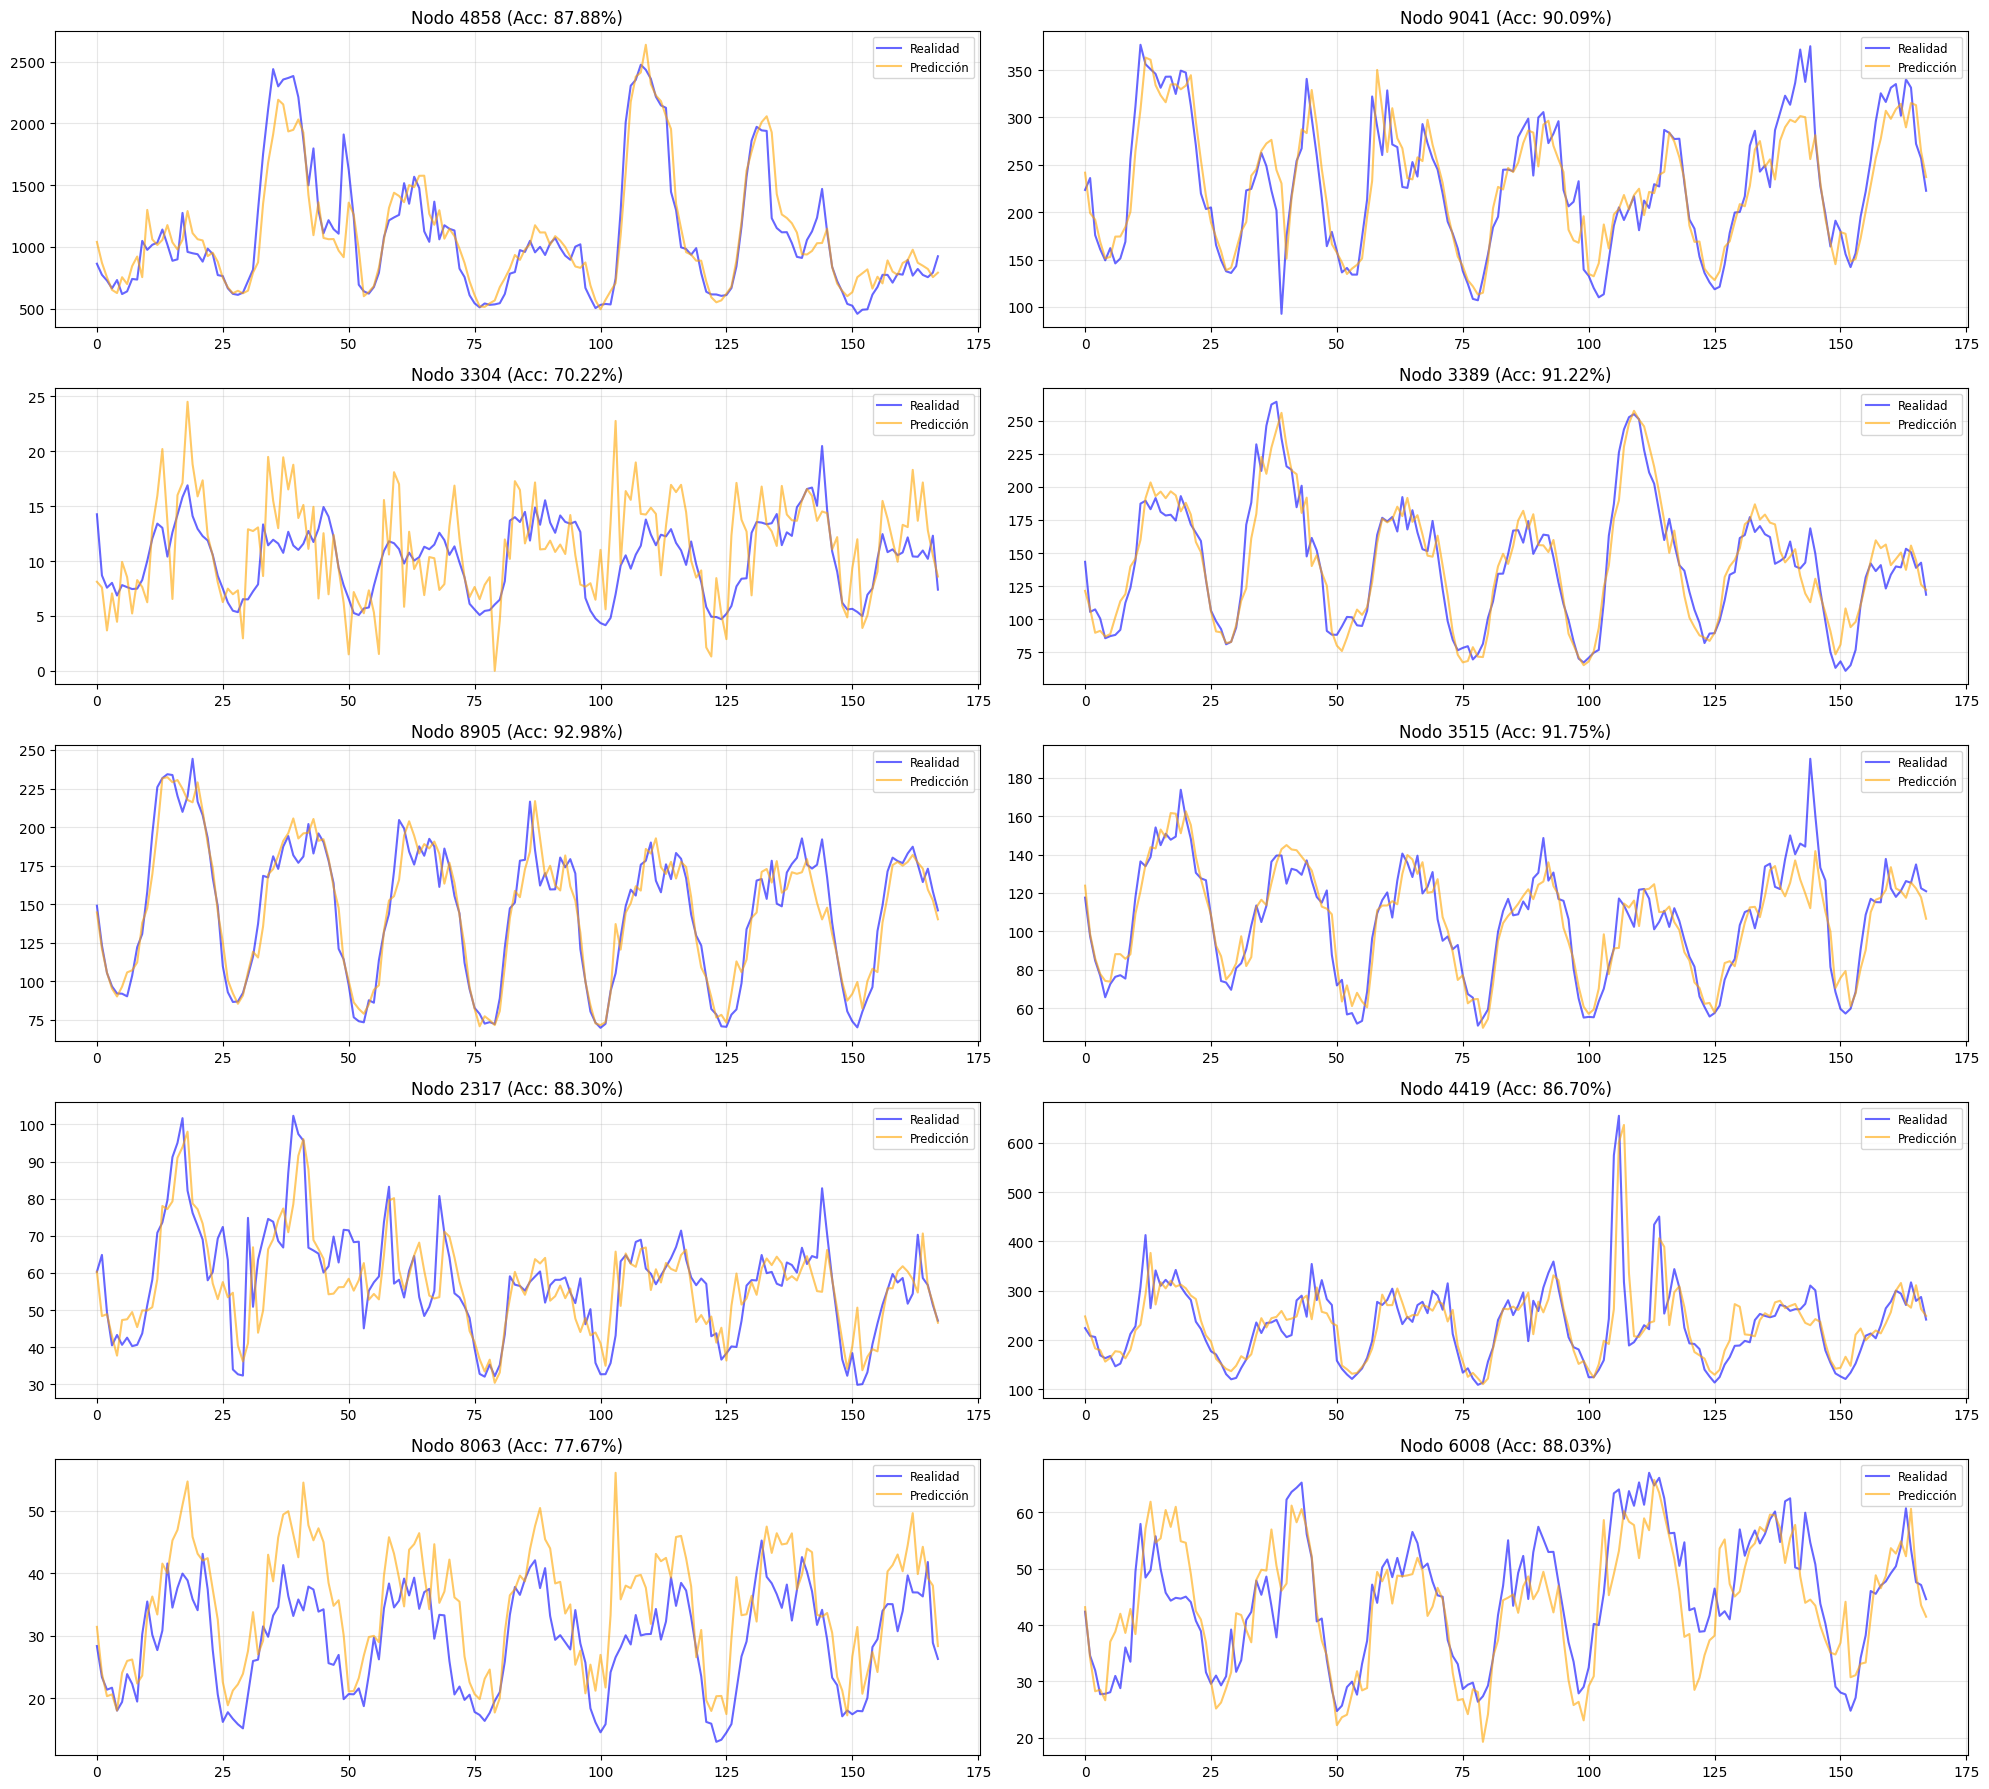

In [12]:
# ... (Tu código anterior de métricas: rmse, accuracy, etc.) ...
print("\nResultados de Evaluación (ST-GNN):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")
print(f"WMAPE: {wmape:.4%}")
print(f"Accuracy: {accuracy:.4%}")
# --- VISUALIZACIÓN MEJORADA (10 Aleatorios) ---
import matplotlib.pyplot as plt
# 1. Nodo con mayor tráfico (Siempre es bueno mantener la referencia del "peor caso" de carga)
mean_traffic_per_node = gt_orig.mean(axis=0).flatten()
max_node_idx = np.argmax(mean_traffic_per_node)
print(f"Visualizando nodo con mayor tráfico: {max_node_idx}")
plt.figure(figsize=(15, 5))
plt.plot(gt_orig[:, max_node_idx, 0], label='Realidad', color='blue', alpha=0.7)
plt.plot(preds_orig[:, max_node_idx, 0], label='Predicción', color='orange', alpha=0.7)
plt.title(f'Predicción vs Realidad (Nodo {max_node_idx} - Max Tráfico)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# 2. Visualizar 10 Celdas Aleatorias
num_plots = 10
# Seleccionamos índices aleatorios (sin repetir)
random_indices = np.random.choice(gt_orig.shape[1], size=num_plots, replace=False)
print(f"Visualizando {num_plots} nodos aleatorios: {random_indices}")
# Creamos una figura grande con subplots (5 filas x 2 columnas)
fig, axes = plt.subplots(5, 2, figsize=(20, 18))
axes = axes.flatten()
for i, node_idx in enumerate(random_indices):
    ax = axes[i]
    ax.plot(gt_orig[:, node_idx, 0], label='Realidad', color='blue', alpha=0.6)
    ax.plot(preds_orig[:, node_idx, 0], label='Predicción', color='orange', alpha=0.6)
    
    # Métricas locales para este nodo (opcional, para ver qué tal va individualmente)
    local_acc = 1 - (np.sum(np.abs(gt_orig[:, node_idx] - preds_orig[:, node_idx])) / np.sum(np.abs(gt_orig[:, node_idx])))
    
    ax.set_title(f'Nodo {node_idx} (Acc: {local_acc:.2%})')
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()